In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib.metadata import version
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

print("Numpy version: " + str(np.__version__))
print("Pandas version: " + str(pd.__version__))
print("Sklearn version: " + str(version("scikit-learn")))
print("Matplotlib version: " + str(version("matplotlib")))

Numpy version: 2.3.5
Pandas version: 2.3.3
Sklearn version: 1.7.2
Matplotlib version: 3.10.7


In [2]:
# Read data
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

df = pd.read_csv(url)

In [3]:
df.shape

(1462, 9)

In [4]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
# Display first 5 rows of data set
print(df.head())

    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


In [6]:
# Descriptives for numeric columns
num_df = df.select_dtypes(include = 'number')

desc = num_df.describe(percentiles = [0.25, 0.5, 0.75]).T
desc = desc.rename(columns = {
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3'
})

print(desc[['min', 'Q1', 'Median', 'mean', 'Q3', 'max', 'std']])

                              min          Q1    Median          mean  \
number_of_courses_viewed      0.0      1.0000      2.00      2.031464   
annual_income             13929.0  49698.0000  60148.00  59886.273224   
interaction_count             0.0      2.0000      3.00      2.976744   
lead_score                    0.0      0.2625      0.51      0.506108   
converted                     0.0      0.0000      1.00      0.619015   

                                Q3       max           std  
number_of_courses_viewed      3.00       9.0      1.449717  
annual_income             69639.00  109899.0  15070.140389  
interaction_count             4.00      11.0      1.681564  
lead_score                    0.75       1.0      0.288465  
converted                     1.00       1.0      0.485795  


### Replace missing values

In [7]:
# Missing values
print("Column missing value counts:\n")
print(df.isnull().sum())

num_missing_cols = df.isnull().any().sum()
print(f"\nThere are {num_missing_cols} columns with missing values.")

Column missing value counts:

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

There are 5 columns with missing values.


In [8]:
# Replace missing values:
df_filled = df.copy()

# Get numeric and non-numeric column lists
numeric_cols = df_filled.select_dtypes(include = 'number').columns
categorical_cols = df_filled.select_dtypes(exclude = 'number').columns

# Fill all at once
df_filled[numeric_cols] = df_filled[numeric_cols].fillna(0.0)
df_filled[categorical_cols] = df_filled[categorical_cols].fillna("NA")

print(df_filled.isnull().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


### Split the data

In [9]:
# Rough idea of ns for train, val, test
n_total = df_filled.shape[0]
p60 = int(n_total * 0.6)
p20 = int(n_total * 0.2)

print(n_total, p60, p20)

1462 877 292


In [10]:
# Separate features and target
X = df_filled.drop(columns = ['converted'])
y = df_filled['converted']

# First, split off 20% for test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 1
)

# Split the remaining 80% into 60% train, 20% val (relative to total data)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size = 0.25, random_state = 1
)  # 0.25 * 0.8 = 0.2

datasets = [X_train_full, X_train, X_val, X_test, y_train_full, y_train, y_val, y_test]

# Reset index for all (drop old index)
for i in range(len(datasets)):
    datasets[i] = datasets[i].reset_index(drop = True)

X_train_full, X_train, X_val, X_test, y_train_full, y_train, y_val, y_test = datasets

# Check sizes
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 876, Val: 293, Test: 293


### Question 1. ROC AUC feature importance

In [11]:
# Get the numerical columns from your training data
numerical_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Calculate AUC for each column
auc_scores = {}

for col in numerical_cols:
    # Calculate AUC
    auc = roc_auc_score(y_train, X_train[col])
    
    # If AUC < 0.5, invert the variable and recalculate
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
    
    auc_scores[col] = auc

# Display results
for col, auc in auc_scores.items():
    print(f"{col}: {auc:.4f}")

# Find the best feature
best_feature = max(auc_scores, key = auc_scores.get)
print(f"\nBest feature: {best_feature} with AUC = {auc_scores[best_feature]:.4f}")

lead_score: 0.6145
number_of_courses_viewed: 0.7636
interaction_count: 0.7383
annual_income: 0.5520

Best feature: number_of_courses_viewed with AUC = 0.7636


In [12]:
# Try scaling the features
# Get the numerical columns from your training data
numerical_cols = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Initialize and fit StandardScaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])

# Calculate AUC for each column
auc_scores = {}
for i, col in enumerate(numerical_cols):
    # Get the scaled column
    scaled_col = X_train_scaled[:, i]
    
    # Calculate AUC
    auc = roc_auc_score(y_train, scaled_col)
    
    # If AUC < 0.5, invert the variable and recalculate
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scaled_col)
    
    auc_scores[col] = auc

# Display results
for col, auc in auc_scores.items():
    print(f"{col}: {auc:.4f}")

# Find the best feature
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nBest feature: {best_feature} with AUC = {auc_scores[best_feature]:.4f}")

lead_score: 0.6145
number_of_courses_viewed: 0.7636
interaction_count: 0.7383
annual_income: 0.5520

Best feature: number_of_courses_viewed with AUC = 0.7636


### Question 2. Model AUC

In [13]:
# Convert train and validation dataframes to dictionaries
train_dicts = X_train.to_dict(orient = 'records')
val_dicts = X_val.to_dict(orient = 'records')

# One-hot encode using DictVectorizer
dv = DictVectorizer(sparse = False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

# Train logistic regression
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 1)
model.fit(X_train_encoded, y_train)

# Predict probabilities on validation set
y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.817


In [14]:
# Try with scaling
# Convert train and validation dataframes to dictionaries
train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')

# One-hot encode using DictVectorizer
dv = DictVectorizer(sparse=False)
X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)

# Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train_scaled, y_train)

# Predict probabilities on validation set
y_val_pred = model.predict_proba(X_val_scaled)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.921


### Question 3. Precision and recall

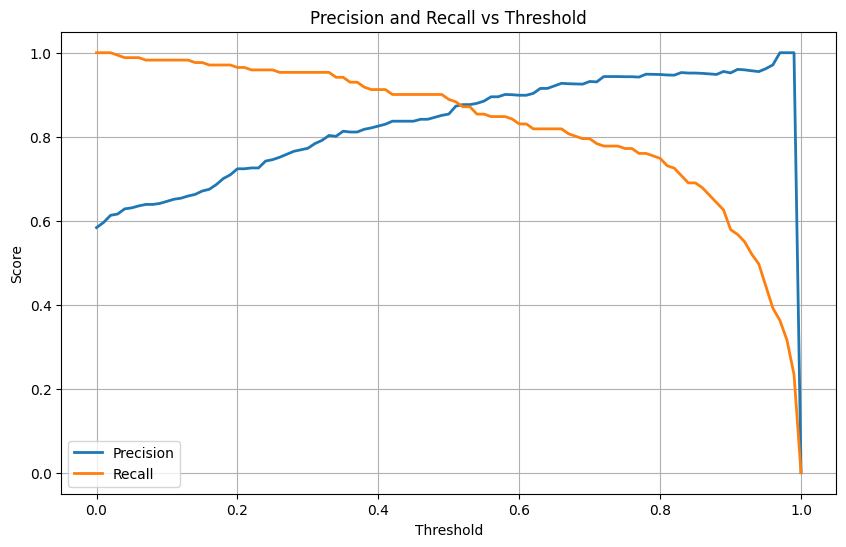

In [15]:
# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

precisions = []
recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    y_pred = (y_val_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred, zero_division = 0)
    recall = recall_score(y_val, y_pred, zero_division = 0)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.figure(figsize = (10, 6))
plt.plot(thresholds, precisions, label = 'Precision', linewidth = 2)
plt.plot(thresholds, recalls, label = 'Recall', linewidth = 2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('Precision and Recall vs Threshold')
plt.show()

In [16]:
# Convert to arrays
p = np.array(precisions)
r = np.array(recalls)

# Compute where sign changes in (p - r)
sign_change = np.where(np.diff(np.sign(p - r)) != 0)[0]

if len(sign_change) > 0:
    i = sign_change[0]
    # Linear interpolation
    t1, t2 = thresholds[i], thresholds[i+1]
    p1, p2 = p[i], p[i+1]
    r1, r2 = r[i], r[i+1]
    
    # Fraction where they cross
    frac = (r1 - p1) / ((p2 - r2) - (p1 - r1))
    intersection_threshold = t1 + frac * (t2 - t1)
else:
    intersection_threshold = np.nan

print(f"Estimated intersection threshold: {intersection_threshold:.3f}")

Estimated intersection threshold: 0.517


### Question 4. F1 score

Maximum F1 score: 0.878
Threshold at maximum F1: 0.51


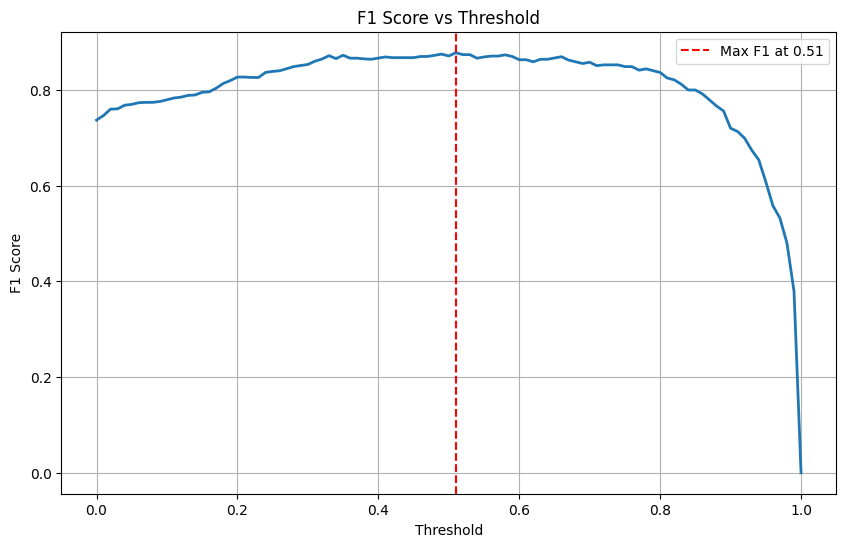

In [17]:
# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

f1_scores = []

# Calculate F1 for each threshold
for threshold in thresholds:
    y_pred = (y_val_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred, zero_division = 0)
    recall = recall_score(y_val, y_pred, zero_division = 0)
    
    # Calculate F1 score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    f1_scores.append(f1)

# Find maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_value:.3f}")
print(f"Threshold at maximum F1: {max_f1_threshold:.2f}")

# Optional: Plot F1 score vs threshold
plt.figure(figsize = (10, 6))
plt.plot(thresholds, f1_scores, linewidth = 2)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.axvline(x = max_f1_threshold, color = 'r', linestyle = '--', label = f'Max F1 at {max_f1_threshold:.2f}')
plt.legend()
plt.grid(True)
plt.title('F1 Score vs Threshold')
plt.show()

### Question 5. 5-Fold CV standard deviation

In [18]:
# Initialize KFold
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# Store AUC scores for each fold
auc_scores = []

# Iterate over folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
    # Split data into train and validation for this fold
    X_fold_train = X_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_train = y_train.iloc[train_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Convert to dictionaries for DictVectorizer
    train_dicts = X_fold_train.to_dict(orient = 'records')
    val_dicts = X_fold_val.to_dict(orient = 'records')
    
    # One-hot encode
    dv = DictVectorizer(sparse = False)
    X_fold_train_encoded = dv.fit_transform(train_dicts)
    X_fold_val_encoded = dv.transform(val_dicts)
    
    # Train model
    model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)
    model.fit(X_fold_train_encoded, y_fold_train)
    
    # Predict and calculate AUC
    y_fold_pred = model.predict_proba(X_fold_val_encoded)[:, 1]
    auc = roc_auc_score(y_fold_val, y_fold_pred)
    
    auc_scores.append(auc)
    print(f"Fold {fold}: AUC = {auc:.3f}")

# Print summary statistics
print(f"\nMean AUC: {np.mean(auc_scores):.3f}")
print(f"Std AUC: {np.std(auc_scores):.3f}")

Fold 1: AUC = 0.805
Fold 2: AUC = 0.827
Fold 3: AUC = 0.866
Fold 4: AUC = 0.847
Fold 5: AUC = 0.818

Mean AUC: 0.833
Std AUC: 0.022


### Question 6. Best C

In [19]:
# C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

# Store results for each C
results = []

# Iterate over C values
for C in C_values:
    print(f"\nTesting C = {C}")
    auc_scores = []
    
    # Iterate over folds
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
        # Split data into train and validation for this fold
        X_fold_train = X_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_train = y_train.iloc[train_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Convert to dictionaries for DictVectorizer
        train_dicts = X_fold_train.to_dict(orient = 'records')
        val_dicts = X_fold_val.to_dict(orient = 'records')
        
        # One-hot encode
        dv = DictVectorizer(sparse = False)
        X_fold_train_encoded = dv.fit_transform(train_dicts)
        X_fold_val_encoded = dv.transform(val_dicts)
        
        # Train model with current C
        model = LogisticRegression(solver = 'liblinear', C = C, max_iter = 1000)
        model.fit(X_fold_train_encoded, y_fold_train)
        
        # Predict and calculate AUC
        y_fold_pred = model.predict_proba(X_fold_val_encoded)[:, 1]
        auc = roc_auc_score(y_fold_val, y_fold_pred)
        
        auc_scores.append(auc)
    
    # Calculate mean and std
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    results.append({
        'C': C,
        'mean_auc': round(mean_auc, 3),
        'std_auc': round(std_auc, 3)
    })
    
    print(f"C = {C}: Mean AUC = {mean_auc:.3f} +/- {std_auc:.3f}")

# Display results in a table
print("\n" + "="*50)
print("Summary:")
print("="*50)
for result in results:
    print(f"C = {result['C']}: Mean = {result['mean_auc']:.3f}, Std = {result['std_auc']:.3f}")

# Find best C (highest mean, then lowest std, then smallest C)
best_result = sorted(results, key=lambda x: (-x['mean_auc'], x['std_auc'], x['C']))[0]
print("="*50)
print(f"Best C: {best_result['C']}")
print(f"Best Mean AUC: {best_result['mean_auc']:.3f}")
print(f"Best Std AUC: {best_result['std_auc']:.3f}")


Testing C = 1e-06
C = 1e-06: Mean AUC = 0.559 +/- 0.031

Testing C = 0.001
C = 0.001: Mean AUC = 0.875 +/- 0.025

Testing C = 1
C = 1: Mean AUC = 0.833 +/- 0.022

Summary:
C = 1e-06: Mean = 0.559, Std = 0.031
C = 0.001: Mean = 0.875, Std = 0.025
C = 1: Mean = 0.833, Std = 0.022
Best C: 0.001
Best Mean AUC: 0.875
Best Std AUC: 0.025
